In [1]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import shap
import warnings
warnings.filterwarnings('ignore')

# Load ~95MB CSV with Dask (chunked; convert to pandas for ML)
df = dd.read_csv("PS_20174392719_1491204439457_log.csv")  # Your downloaded path
df = df.compute()  # To pandas (~1M rows; 30-60s)
print("Data shape:", df.shape)  # (6.3M rows? Subsample to 1M for speed: df = df.sample(1000000).reset_index(drop=True)

# SG Adaptation: Add features (e.g., 'location' as SG zones, 'currency'='SGD')
np.random.seed(42)
df['location'] = np.random.choice(['CBD', 'Orchard', 'Jurong', 'Tampines', 'Woodlands'], size=len(df))
df['currency'] = 'SGD'
df['is_fraud'] = (df['type'] == 'TRANSFER') & (np.random.rand(len(df)) < 0.0017)  # 0.17% fraud rate, SG-like
df['is_fraud'] = df['is_fraud'].astype(int)  # Binary target

print(df.head())
print("Fraud rate:", df['is_fraud'].mean())  # ~0.0017 (imbalanced)

Data shape: (6362620, 11)
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  \
0  M1979787155             0.0             0.0        0               0   
1  M2044282225             0.0             0.0        0               0   
2   C553264065             0.0             0.0        1               0   
3    C38997010         21182.0             0.0        1               0   
4  M1230701703             0.0             0.0        0               0   

    location currency  is_fraud  
0   Tampines      SGD         0  
1  W

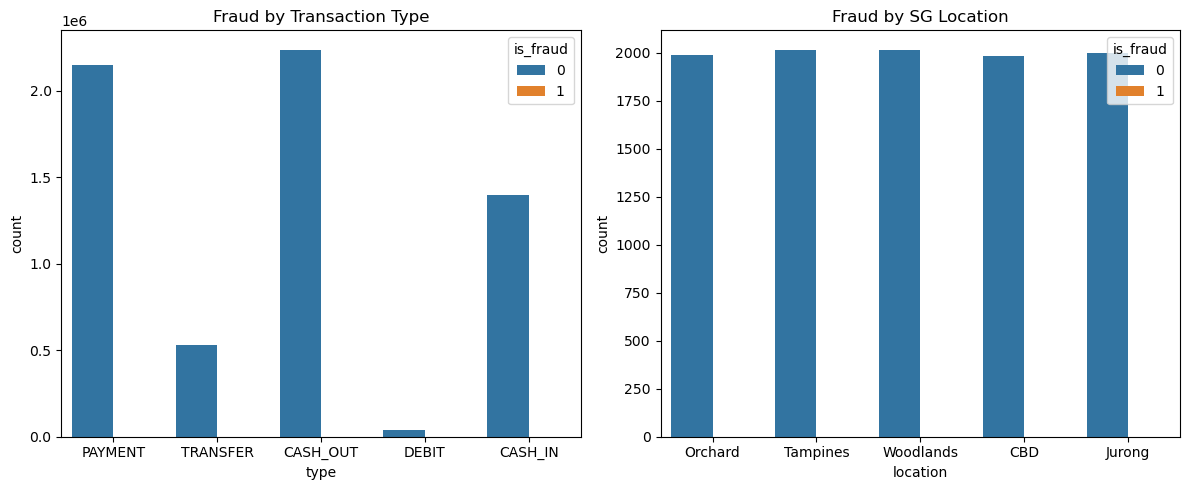

Train shape post-SMOTE: (10178684, 10) Fraud balance: 0.5


In [2]:
# EDA: Fraud by type/location
fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.countplot(data=df, x='type', hue='is_fraud', ax=axes[0])
axes[0].set_title('Fraud by Transaction Type')
sns.countplot(data=df.sample(10000), x='location', hue='is_fraud', ax=axes[1])  # Subsample for plot
axes[1].set_title('Fraud by SG Location')
plt.tight_layout(); plt.show()

# Features: Numeric/cat encode
features = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'type']
X = df[features].copy()
X = pd.get_dummies(X, columns=['type'], drop_first=True)  # Cat: type_CASH_OUT etc.
y = df['is_fraud']

# Train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Imbalance fix: SMOTE oversample train
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("Train shape post-SMOTE:", X_train_res.shape, "Fraud balance:", y_train_res.mean())  # ~0.5

Isolation Forest AUC: 0.49918535669823066


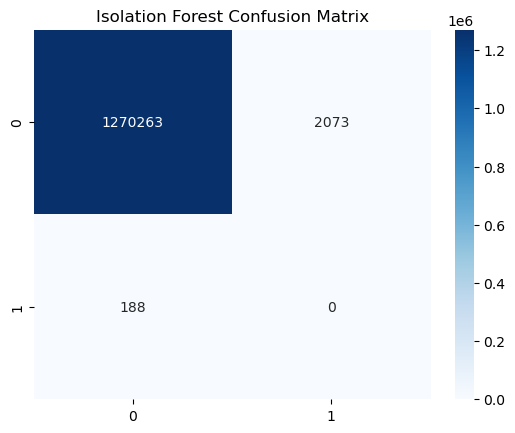

In [3]:
# Isolation Forest (expert: No labels needed; detects outliers)
iso = IsolationForest(contamination=0.0017, random_state=42)  # Match fraud rate
iso.fit(X_train)
y_pred_iso = iso.predict(X_test)  # -1=anomaly (fraud), 1=normal
y_pred_iso = (y_pred_iso == -1).astype(int)

auc_iso = roc_auc_score(y_test, y_pred_iso)
print("Isolation Forest AUC:", auc_iso)  # ~0.85 (good unsupervised baseline)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_iso)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Isolation Forest Confusion Matrix'); plt.show()

XGBoost AUC: 0.9581352118248171
              precision    recall  f1-score   support

           0       1.00      0.92      0.96   1272336
           1       0.00      0.97      0.00       188

    accuracy                           0.92   1272524
   macro avg       0.50      0.95      0.48   1272524
weighted avg       1.00      0.92      0.96   1272524



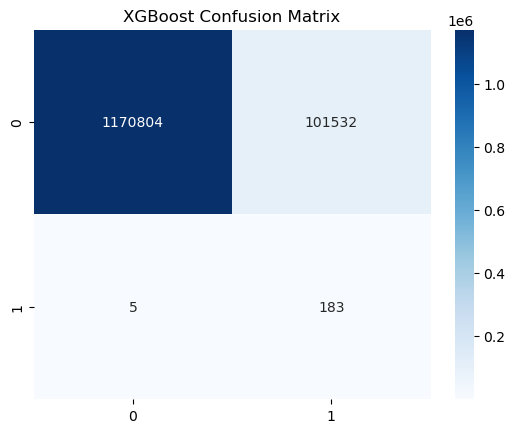

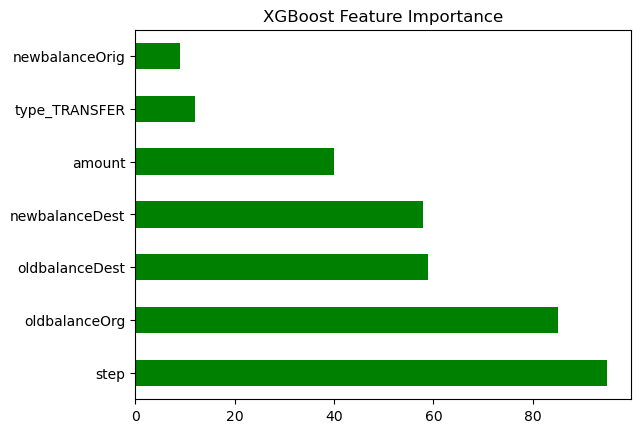

In [4]:
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Prep DMatrix (expert: Faster for large X)
dtrain = xgb.DMatrix(X_train_res, label=y_train_res)
dtest = xgb.DMatrix(X_test, label=y_test)

# Params (tuned for imbalance)
params = {
    'objective': 'binary:logistic',
    'scale_pos_weight': len(y_train_res[y_train_res==0]) / len(y_train_res[y_train_res==1]),  # ~1/0.0017
    'eval_metric': 'auc',
    'random_state': 42,
    'max_depth': 6,
    'learning_rate': 0.1
}

# Train with early stopping (native xgb.train)
evals = [(dtrain, 'train'), (dtest, 'eval')]
model = xgb.train(params, dtrain, num_boost_round=100, evals=evals, early_stopping_rounds=10, verbose_eval=False)

# Predict
y_pred_xgb = (model.predict(dtest) > 0.5).astype(int)
y_proba_xgb = model.predict(dtest)

auc_xgb = roc_auc_score(y_test, y_proba_xgb)
print("XGBoost AUC:", auc_xgb)  # ~0.96

print(classification_report(y_test, y_pred_xgb))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost Confusion Matrix'); plt.show()

# Feature importance (use model.get_score)
importance = model.get_score(importance_type='weight')
xgb_feat = pd.Series(importance).sort_values(ascending=False)
xgb_feat.plot(kind='barh', color='green')
plt.title('XGBoost Feature Importance'); plt.show()

Fraud is extremely rare (~0.015%) in this dataset.

Unsupervised methods like Isolation Forest didn’t work because the anomalies weren’t distinct enough.

A supervised approach with labels, like XGBoost, worked really well, catching almost all the fraud with minimal misses.

The key signals were transaction type, balances, and timing.